In [31]:
# %config StoreMagics.autorestore = True
# %reset -f
# %store -z
# %store -r
# %whos

In [32]:
import numpy
import sympy
import scipy
import control
import matplotlib.pyplot as plt

from custom_utils import ControlUtils
from custom_utils import ODEUtils

from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML

numpy.set_printoptions(precision=3)
sympy.init_printing(use_latex='mathjax', use_unicode=True)
sympy.init_printing()
plt.rcParams.update({ "text.usetex": True, "font.family": "Helvetica", "axes.titley": 1.0 })
%matplotlib inline

Example plant for naive MOR 

<IPython.core.display.Math object>

(array([8.339e-02, 8.339e-02, 8.339e-02, ..., 2.905e-06, 2.891e-06,
        2.877e-06]),
 array([-6.255e-04, -6.264e-04, -6.273e-04, ..., -5.484e+00, -5.484e+00,
        -5.483e+00]),
 array([  0.1  ,   0.1  ,   0.1  , ...,  99.724,  99.862, 100.   ]))

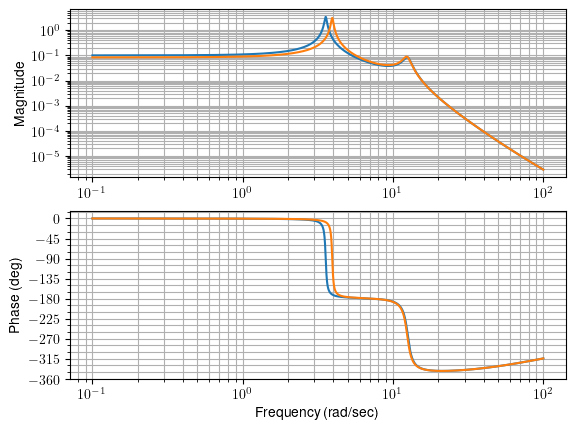

In [33]:
# Parameters
m1 = 0.25
m2 = 0.1
k1 = 5
k2 = 10
d1 = 0.05
d2 = 0.075

# Feedback gain
K = control.TransferFunction(2,1)
K = control.tf2ss(K)

Au = numpy.vstack([numpy.array([0,1,0,0],dtype=numpy.float64),
                   numpy.array([-k1/m1,-d1/m1,k1/m1,d1/m1],dtype=numpy.float64),
                   numpy.array([0,0,0,1],dtype=numpy.float64),
                   numpy.array([k1/m2,d1/m2,-(k1+k2)/m2,-(d1+d2)/m2],dtype=numpy.float64)])
Bu = numpy.array([0,1/m1,0,0],dtype=numpy.float64).reshape((4,1))
Cu = numpy.array([0,0,1,0],dtype=numpy.float64)
massSpringSys = control.ss(Au,Bu,Cu,0)
massSpringSyscl = control.feedback(massSpringSys,K,sign=-1)
display(Math('\\lVert eig(A_{u,cl}) \\rVert_{\\infty} = ' + str(numpy.linalg.eigvals(massSpringSyscl.A))))

# Bode plot
freq = numpy.logspace(-1,2,5000) # rads/sec
control.bode_plot(massSpringSys, freq, wrap_phase=False, deg=True)
control.bode_plot(massSpringSyscl, freq, wrap_phase=False, deg=True)

Applying MOR

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

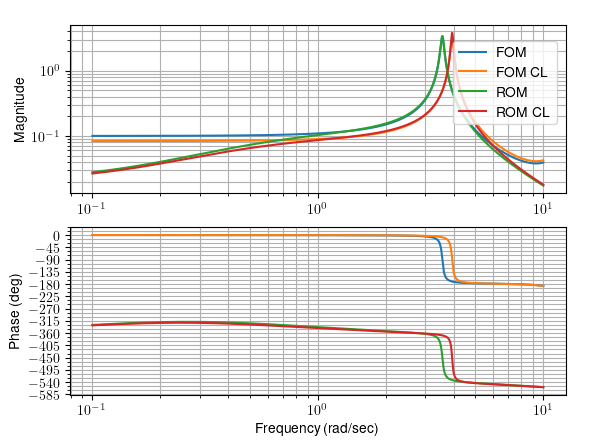

In [34]:
reducOrder = 3
hatMassSpringSys, hsvMassSpringSys, _ = ControlUtils.balaced_truncation(massSpringSys, reducOrder)
normInfHatMassSpringSys, normInfHatMassSpringSys_MIMO = ControlUtils.hinfnorm(hatMathcalPext)
display(Math('\\lVert \\widehat{P} \\rVert_{\\infty} = ' + str(normInfHatMassSpringSys)))

# Getting reduction error bound
epsilon = numpy.sum(hsvMassSpringSys[reducOrder:])
display(Math('\\epsilon_{ext} = \\sum_{i=\\hat{n}_p+1}^{n_p} \\sigma_{i} = ' + str(epsilon)))

# Bode plot
freq = numpy.logspace(-1,1,5000) # rads/sec
hatMassSpringSyscl = control.feedback(hatMassSpringSys,K,sign=-1)
display(Math('\\lVert eig(\\hat{A}_{u,cl}) \\rVert_{\\infty} = ' + str(numpy.linalg.eigvals(hatMassSpringSyscl.A))))
control.bode_plot(massSpringSys, freq, wrap_phase=False, deg=True)
control.bode_plot(massSpringSyscl, freq, wrap_phase=False, deg=True)
control.bode_plot(hatMassSpringSys, freq, wrap_phase=False, deg=True)
control.bode_plot(hatMassSpringSyscl, freq, wrap_phase=False, deg=True)
plt.figlegend( ['FOM','FOM CL', 'ROM', 'ROM CL'], borderaxespad=3 )

In [35]:
# Simulation parameters
Tsam = 0.1
T_step = Tsam/100
t_ini = 0
t_fin = 60*5
steps = int(numpy.ceil((t_fin-t_ini)/T_step))

tkVec = numpy.arange(t_ini, t_fin, Tsam)
tVec = numpy.linspace(t_ini, t_fin, steps)
uVec = 1*numpy.sin(3.9*tVec)

xp0 = 0*numpy.ones((massSpringSyscl.A.shape[0],1))
hatxp0 = 0*numpy.ones((hatMassSpringSyscl.A.shape[0],1))

In [36]:
# FOM
resultFOM = control.input_output_response(massSpringSyscl, tVec.reshape(-1), uVec.reshape(-1), 
                                          xp0, t_eval=tVec.reshape(-1))

In [37]:
# ROM
resultROM = control.input_output_response(hatMassSpringSyscl, tVec.reshape(-1), uVec.reshape(-1),
                                          hatxp0, t_eval=tVec.reshape(-1))

In [38]:
# Sampled FOM
xpVecFOM, xcVecFOM, vsVecFOM, whVecFOM = ODEUtils.solveSDLinearSystem(plant=massSpringSys,
                                                          discrete_controller=-K,
                                                          xp0=xp0,
                                                          xc0=0*numpy.random.rand(*(K.A.shape[0], 1)),
                                                          uVec=uVec, t_ini=t_ini, t_fin=t_fin, T_step=T_step, T_samps=tkVec)

In [39]:
# Sampled ROM
xpVecROM, xcVecROM, vsVecROM, whVecROM = ODEUtils.solveSDLinearSystem(plant=hatMassSpringSys,
                                                          discrete_controller=-K,
                                                          xp0=hatxp0,
                                                          xc0=0*numpy.random.rand(*(K.A.shape[0], 1)),
                                                          uVec=uVec, t_ini=t_ini, t_fin=t_fin, T_step=T_step, T_samps=tkVec)

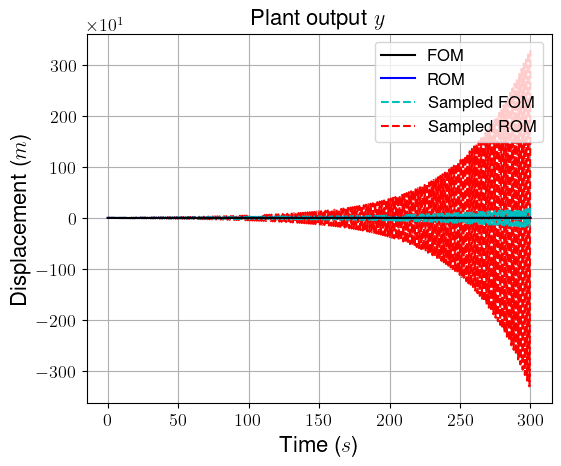

In [47]:
# Compute outputs
tLims = [t_ini,t_fin]
idxLims = range(numpy.where(tVec[:] >= tLims[0])[0][0], numpy.where(tVec[:] >= tLims[1])[0][0] + 1)

yVecFOM = resultFOM.outputs[:,None].T
yVecROM = resultROM.outputs[:,None].T

yVecSampledFOM = massSpringSys.C[0:1,:] @ xpVecFOM
yVecSampledROM = hatMassSpringSys.C[0:1,:] @ xpVecROM

plt.plot(tVec[idxLims], yVecSampledROM[0, idxLims], 'r', label="Sampled ROM", linestyle='dashed')
plt.plot(tVec[idxLims], yVecSampledFOM[0, idxLims], 'c', label="Sampled FOM", linestyle='dashed')
plt.plot(tVec[idxLims], yVecROM[0, idxLims], 'b', label="ROM", linestyle='solid')
plt.plot(tVec[idxLims], yVecFOM[0, idxLims], 'k', label="FOM", linestyle='solid')
plt.ticklabel_format(axis='y', scilimits=(1,1))
plt.tick_params(axis='y', labelsize=13)
plt.tick_params(axis='x', labelsize=13)
plt.gca().yaxis.get_offset_text().set_fontsize(13)
plt.gca().xaxis.get_offset_text().set_fontsize(13)
plt.title('Plant output $y$', fontsize=16)
plt.xlabel('Time ($s$)', fontsize=16)
plt.ylabel('Displacement ($m$)', fontsize=16)
handles, labels = plt.gca().get_legend_handles_labels()
handles_order = [3,2,1,0]
plt.legend([handles[idx] for idx in handles_order],[labels[idx] for idx in handles_order],loc='upper right', fontsize=12)
plt.grid()
plt.gcf().set_figwidth(6)
# plt.ylim([-20,20])
plt.savefig('example_naive_mor_unstable.png', format='png', transparent=True, bbox_inches="tight", pad_inches=0.1)
plt.show()